In [2]:
library(ppcor)
#install.packages('lmPerm')
library(lmPerm)
library(psych)
library(car)
library(ggplot2)
library(lme4)
library(mediation)
library(caret)
library(gbm)
library(party)
library(Metrics)
#install.packages("wesanderson")
library(wesanderson)
library(gtools)
library(interactions)
#install.packages('ggstance')
library(ggstance)
#install.packages('elasticnet')
library(elasticnet)
#install.packages('kernlab')
library(kernlab)
#install.packages('e1071')
library(e1071)
#install.packages('MatchIt')
library(MatchIt)
library(dplyr)
library(ukbtools)
library(mediation)
library(lavaan)
library(lavaanPlot)
library(plotly)
library(MVN)
#install.packages('MissMech')
library(semTools)
library(MissMech)
#install.packages('aod')
library(aod)
options(warn=-1)

# Read in the data 

In [3]:
di=read.table('/dagher/dagher11/filip/PRSOB/data/brain_data.csv', header=TRUE, na.strings = "", sep=',', quote = "\"")
cov19=read.table('/dagher/dagher11/filip/COVID/data/covid19_result.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
cov19= cov19[order(cov19$result, decreasing=TRUE),] 

covidinf=cov19
covidinf=covidinf[!duplicated(covidinf$eid),]
cov_base=covidinf

death=read.table('/dagher/dagher11/filip/COVID/data/death_cause.txt', header=TRUE, na.strings = "", sep='\t', quote = "\"")
death=(death[death$level==1 & death$cause_icd10=='U071',]) # take only individuals whose primary cause of death was COVID

## Add hypertension and diabetes diagnosis

In [4]:
di$hypertension <- 0
for (i in as.numeric(grep('vascularheart_problems_diagnosed_by_doctor', colnames(di)))) { 
    di$hypertension[di[i] == 'High blood pressure'] <- 1 # Hypertension
}

# Mark participants who have diabetes - self-reported
di$diabetes <- 0
for (i in as.numeric(grep('diabetes_diagnosed_by_doctor', colnames(di)))) { 
    di$diabetes[di[i] =="Yes"] <- 1
}

# Mark participants with hypertension - diagnosed
di$hypertension2 <- 0
for (i in as.numeric(grep('icd10', colnames(di)))) { 
    di$hypertension2[di[i] == 'I10 Essential (primary) hypertension'] <- 1 # Hypertension
    }

# Mark participants who have diabetes - diagnoses
exclusions_diabetes=c('^E10','^E11','^E12','^E13','^E14')
di$diabetes2 <- NA
for (i in as.numeric(grep('icd10', colnames(di)))) {
    for (d in 1:length(exclusions_diabetes)) {
        di$diabetes2[grepl(exclusions_diabetes[d], di[[i]])] = 1
    }
}

di$Hypertension=0
di$Hypertension[di$hypertension=='1' | di$hypertension2=='1']=1
di$Diabetes=0
di$Diabetes[di$diabetes=='1' | di$diabetes2=='1']=1

In [5]:
fasting=read.table('/dagher/dagher11/filip/COVID/data/glucose.csv',sep=',', header=T)
fasting=select(fasting,-c(eid))

# MetS latent variable and OR - covid infection

## Create dataframes

In [7]:
covidinf=merge(di, covidinf, by='eid')

covidinf$TG=(log(covidinf$triglycerides_30870.0.0))
covidinf$HDL=(log(covidinf$hdl_cholesterol_30760.0.0))
covidinf$Sex=as.factor(covidinf$sex_31.0.0)
covidinf$Waist=(covidinf$waist_circumference_48.0.0)
covidinf$HbA1c=(log(covidinf$glycated_haemoglobin_hba1c_30750.0.0))
covidinf$systolicBP=(rowMeans(cbind(covidinf$systolic_blood_pressure_automated_reading_4080.0.0,
                                      covidinf$systolic_blood_pressure_automated_reading_4080.0.1)))
covidinf$diastolicBP=(rowMeans(cbind(covidinf$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       covidinf$diastolic_blood_pressure_automated_reading_4079.0.1)))
covidinf$glucose=(log(covidinf$glucose_30740.0.0))
covidinf$CRP=(log(covidinf$c.reactive_protein_30710.0.0))


COVinf=select(covidinf, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, eid,
             sex_31.0.0, year_of_birth_34.0.0, waist_circumference_48.0.0, hip_circumference_49.0.0,
              body_mass_index_bmi_21001.0.0, glucose_30740.0.0,glycated_haemoglobin_hba1c_30750.0.0,
              hdl_cholesterol_30760.0.0)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}

COVinf=na.omit(COVinf)

COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

nrow(COVinf)

COVinf=merge(COVinf,fasting, by=c('sex_31.0.0','year_of_birth_34.0.0', 'waist_circumference_48.0.0', 
                                  'hip_circumference_49.0.0','glucose_30740.0.0',
                                 'glycated_haemoglobin_hba1c_30750.0.0', 'hdl_cholesterol_30760.0.0'), all.x=TRUE)


COVinf$HDL=-1*COVinf$HDL

COVinf$glucose=resid(lm(glucose ~ fasting_time_74.0.0, data=COVinf))

[1] 12659

In [13]:
char=merge(COVinf, covidinf, by='eid', all.x=TRUE)

sum(char$result.x)

[1] 1138

# Values before log-transformation

### SARS-CoV-2 positive

In [14]:
char=merge(COVinf, covidinf, by='eid', all.x=TRUE)
char=char[char$result.x==1,]
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char) 


         1 
0.08989652 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1952.304,9.127495,1951.5,1952.109,12.6021,1937,1969,32,0.1585154,-1.344796,0.2705705



  Female     Male 
0.473638 0.526362 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,93.38489,13.8909,93,92.93136,13.3434,62,142,80,0.3321258,0.1348789,0.4117745


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,35.82935,4.505349,35.3,35.5716,3.85476,24,53.2,29.2,0.662114,1.039397,0.1335541


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,3.000369,5.229767,1.59,1.991031,1.497426,0.09,63.93,63.84,6.35055,55.08959,0.1550284


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,4.983326,0.6371266,4.916,4.936264,0.5404077,3.338,7.572,4.234,0.8172972,1.335378,0.01888664


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1.361864,0.3431419,1.3185,1.337944,0.3328437,0.511,2.954,2.443,0.70471,0.6325755,0.01017191


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,1.788083,1.039995,1.521,1.640004,0.8087583,0.461,10.856,10.395,1.977366,7.691448,0.03082906


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,137.1977,18.58658,134.5,136.2522,18.5325,91.5,204.5,113,0.5311468,0.220753,0.5509704


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,1138,82.45782,10.25369,82,82.30263,9.6369,48,118.5,70.5,0.2016658,0.2175487,0.3039547



         0          1 
0.90509666 0.09490334 


        0         1 
0.5834798 0.4165202 

### SARS-CoV-2 negative

In [15]:
char=merge(COVinf, covidinf, by='eid', all.x=TRUE)
char=char[char$result.x==0,]
table(char$result.x)/nrow(COVinf)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char) 


        0 
0.9101035 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1950.016,8.128044,1948,1949.422,8.8956,1937,1970,33,0.5581258,-0.7645892,0.07572529



   Female      Male 
0.5232185 0.4767815 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,92.06818,13.68869,92,91.63175,13.3434,57,143,86,0.3247418,-0.03190711,0.1275313


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,35.76357,4.327334,35.5,35.55213,3.7065,23.9,53.7,29.8,0.6563347,1.475758,0.0403158


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,2.836558,4.447098,1.49,1.92271,1.378818,0.08,71.31,71.23,5.364848,43.26239,0.04143159


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,5.003087,0.6286926,4.937,4.960785,0.5070492,3.292,7.568,4.276,0.8219338,1.662386,0.005857243


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1.432801,0.3845299,1.381,1.40333,0.3647196,0.53,3.524,2.994,0.841408,1.099048,0.003582491


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,1.768551,1.015978,1.522,1.620799,0.7768824,0.272,10.664,10.392,1.982265,6.745047,0.009465405


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,138.5533,18.55339,137,137.7761,18.5325,87,205,118,0.4141962,0.05438034,0.1728535


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,11521,82.23514,9.935423,82,82.05951,10.3782,49,119.5,70.5,0.1773649,0.01289526,0.09256382



         0          1 
0.92170819 0.07829181 


        0         1 
0.5767728 0.4232272 

## CFA

In [29]:
COVID_infection = '
#Latent variables

HypertensionLatent =~  diastolicBP + systolicBP  + Hypertension
DiabetesLatent =~ HbA1c + glucose  + Diabetes
DysL =~ a*TG + a*HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP

systolicBP ~~ diastolicBP
'


COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 47 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         23
                                                      
  Number of observations                         12659
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                              1770.690    1668.342
  Degrees of freedom                                32          32
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.061
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                             25699.513   22836.916
  Degrees of freedom                                45          45
  P-value                        

## Logistic regression

In [30]:
### Get latent variable scores

COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,4]

### Run logistic regression

metsinf_logit=(glm(result ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = result ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2477  -0.4652  -0.3839  -0.3150   2.7148  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                    -7.428e+01
townsend_deprivation_index_at_recruitment_189.0.0.x                             9.829e-02
MetS                                                                            9.608e-02
sex_31.0.0Male                                                                  2.117e-01
year_of_birth_34.0.0                                              

In [31]:
exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),5.488267e-33,4.027161e-40,7.625129e-26
townsend_deprivation_index_at_recruitment_189.0.0.x,1.103281e+00,1.030873e+00,1.180144e+00
MetS,1.100842e+00,9.956848e-01,1.216459e+00
sex_31.0.0Male,1.235771e+00,1.077531e+00,1.417729e+00
year_of_birth_34.0.0,1.037517e+00,1.028841e+00,1.046254e+00
laboratory,1.009702e+00,1.007787e+00,1.011617e+00
spectype,1.021889e+00,1.009615e+00,1.034030e+00
qualifications_6138.0.0College or University degree,9.355011e-01,7.403087e-01,1.189388e+00
qualifications_6138.0.0CSEs or equivalent,1.401957e+00,1.033097e+00,1.898594e+00
qualifications_6138.0.0None of the above,1.383834e+00,1.079786e+00,1.783456e+00


# MetS latent variable and OR - covid mortality

## Create dataframes

In [30]:
covidinf=cov_base
covidinf=covidinf[!duplicated(covidinf$eid),]
covidinf=merge(di, covidinf, by='eid')
cov_pos=(covidinf[covidinf$result==1,]) # take only people who tested positive
coviddeath=merge(cov_pos, death, by='eid',all.x=T) # merge with death records
coviddeath$level[is.na(coviddeath$level)]=0 # recode

In [31]:
coviddeath$TG=scale(log(coviddeath$triglycerides_30870.0.0))
coviddeath$HDL=scale(log(coviddeath$hdl_cholesterol_30760.0.0))
coviddeath$Sex=as.factor(coviddeath$sex_31.0.0)
coviddeath$Waist=scale(coviddeath$waist_circumference_48.0.0)
coviddeath$HbA1c=scale(log(coviddeath$glycated_haemoglobin_hba1c_30750.0.0))
coviddeath$systolicBP=scale(rowMeans(cbind(coviddeath$systolic_blood_pressure_automated_reading_4080.0.0,
                                      coviddeath$systolic_blood_pressure_automated_reading_4080.0.1)))
coviddeath$diastolicBP=scale(rowMeans(cbind(coviddeath$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       coviddeath$diastolic_blood_pressure_automated_reading_4079.0.1)))
coviddeath$glucose=scale(log(coviddeath$glucose_30740.0.0))
coviddeath$CRP=scale(log(coviddeath$c.reactive_protein_30710.0.0))


COVinf=select(coviddeath, TG, HDL, Sex, Hypertension, Diabetes, result,
          laboratory, origin, spectype, qualifications_6138.0.0, townsend_deprivation_index_at_recruitment_189.0.0,
          Waist, year_of_birth_34.0.0, smoking_status_20116.0.0,
          ethnic_background_21000.0.0, HbA1c, systolicBP, diastolicBP, glucose,
             average_total_household_income_before_tax_738.0.0, sex_31.0.0, CRP, level, eid,
              sex_31.0.0, year_of_birth_34.0.0, waist_circumference_48.0.0, hip_circumference_49.0.0,
         glucose_30740.0.0,glycated_haemoglobin_hba1c_30750.0.0,
            hdl_cholesterol_30760.0.0)



for (j in c(1, 2, 11, 12, 16, 17, 18, 19, 22)) { # 
    Q3=as.numeric(quantile(COVinf[j],0.75, na.rm=TRUE))
    Q1=as.numeric(quantile(COVinf[j],0.25, na.rm=TRUE))
    upper=Q3+(2.2*(Q3-Q1))
    lower=Q1-(2.2*(Q3-Q1))
    COVinf[j][COVinf[j]<lower]=NA
    COVinf[j][COVinf[j]>upper]=NA
    COVinf[j]=scale(COVinf[j])
}


COVinf$Hypertension=as.numeric(COVinf$Hypertension)
COVinf$Diabetes=as.numeric(COVinf$Diabetes)

COVinf=na.omit(COVinf)

nrow(COVinf)

COVinf=merge(COVinf,fasting, by=c('sex_31.0.0','year_of_birth_34.0.0', 'waist_circumference_48.0.0', 
                                  'hip_circumference_49.0.0','glucose_30740.0.0',
                                 'hdl_cholesterol_30760.0.0','glycated_haemoglobin_hba1c_30750.0.0'), all.x=TRUE)

COVinf$HDL=-1*COVinf$HDL

COVinf$glucose=resid(lm(glucose ~ fasting_time_74.0.0, data=COVinf))



[1] 1152

In [32]:
sum(COVinf$level)

[1] 180

## Sample characteristics - values before transformations!

### COVID survivors

In [19]:
char=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
char=char[char$level.x==0,]
table(char$level.x)/nrow(char)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char)


0 
1 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,1953.442,9.052984,1954,1953.459,11.8608,1937,1969,32,-0.008751376,-1.357239,0.2903746



   Female      Male 
0.4907407 0.5092593 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,92.55154,13.61791,92,92.13638,13.3434,62,139,77,0.3013247,0.06799578,0.4367946


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,35.73313,4.621993,35.2,35.43895,3.85476,24,54.7,30.7,0.810849,1.597167,0.1482505


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,2.88606,5.142509,1.55,1.897121,1.445535,0.09,66.24,66.15,6.765148,63.05964,0.1649461


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,4.952096,0.6285481,4.8805,4.902548,0.5248404,3.269,7.812,4.543,0.9488837,1.960684,0.02016069


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,1.365096,0.3488537,1.322,1.341048,0.3417393,0.511,2.954,2.443,0.6852936,0.5714034,0.01118949


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,1.775579,1.047056,1.5175,1.625276,0.8109822,0.461,10.856,10.395,2.095374,8.675904,0.03358433


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,135.7145,18.15189,133,134.7076,17.7912,91.5,204.5,113,0.5801877,0.3676232,0.5822223


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,972,82.20936,10.3119,81.5,82.0482,9.6369,48,118.5,70.5,0.2176547,0.2365661,0.3307545



         0          1 
0.91049383 0.08950617 


        0         1 
0.6183128 0.3816872 

## COVID mortality group

In [20]:
char=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
char=char[char$level.x==1,]
table(char$level.x)/nrow(char)
describe(char$year_of_birth_34.0.0.x)
table(char$sex_31.0.0.x)/nrow(char)
describe(char$waist_circumference_48.0.0.x)
describe(char$glycated_haemoglobin_hba1c_30750.0.0.x)
describe(char$c.reactive_protein_30710.0.0)
describe(char$glucose_30740.0.0.x)
describe(char$hdl_cholesterol_30760.0.0.x)
describe(char$triglycerides_30870.0.0)
describe((rowMeans(cbind(char$systolic_blood_pressure_automated_reading_4080.0.0,
                                      char$systolic_blood_pressure_automated_reading_4080.0.1))))
describe(rowMeans(cbind(char$diastolic_blood_pressure_automated_reading_4079.0.0,
                                       char$diastolic_blood_pressure_automated_reading_4079.0.1)))
table(char$Diabetes.x)/nrow(char)
table(char$Hypertension.x)/nrow(char)


1 
1 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,1945.7,6.243567,1944,1944.826,4.4478,1938,1966,28,1.173092,0.8313881,0.465368



   Female      Male 
0.3666667 0.6333333 

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,98.61611,14.47821,97,98.14097,14.0847,68,142,74,0.3882984,0.1097336,1.079142


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,36.98944,5.233065,36.15,36.62083,4.22541,23.2,55.8,32.6,0.8269979,1.580628,0.3900497


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,3.975556,7.223022,2.1,2.572431,2.07564,0.1,63.93,63.83,5.516725,36.67144,0.5383723


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,5.19425,0.7427305,5.126,5.160035,0.6567918,3.431,7.498,4.067,0.4516618,0.2660546,0.05535987


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,1.345178,0.3161273,1.2995,1.32141,0.2898483,0.723,2.41,1.687,0.7933539,0.7965638,0.02356274


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,1.881439,1.007062,1.628,1.74316,0.8139474,0.495,5.284,4.789,1.170618,0.8741212,0.07506198


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,145.7583,18.33354,146.75,145.1562,18.16185,104,202.5,98.5,0.2712585,0.01412596,1.366501


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X1,1,180,84.025,10.02696,84.25,83.81597,9.6369,58.5,110.5,52,0.178415,0.09739533,0.7473653



        0         1 
0.8444444 0.1555556 


        0         1 
0.3777778 0.6222222 

## CFA

In [33]:
COVID_infection = '
#Latent variables

HypertensionLatent =~  diastolicBP + systolicBP  + Hypertension
DiabetesLatent =~ HbA1c + glucose  + Diabetes
DysL =~ a*TG + a*HDL

MetS =~ Waist + DysL + HypertensionLatent + DiabetesLatent + CRP

diastolicBP~~systolicBP
HbA1c ~~ glucose

'

COVID_fitinf <- cfa(COVID_infection, data=COVinf, estimator='MLM')
summary(COVID_fitinf, standardized=TRUE, fit.measures=T)
#fitmeasures(WMHOB_fit) #fit indices

lavaan 0.6-7 ended normally after 44 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of free parameters                         24
                                                      
  Number of observations                          1152
                                                      
Model Test User Model:
                                              Standard      Robust
  Test Statistic                               212.742     194.245
  Degrees of freedom                                31          31
  P-value (Chi-square)                           0.000       0.000
  Scaling correction factor                                  1.095
       Satorra-Bentler correction                                 

Model Test Baseline Model:

  Test statistic                              2387.856    2096.836
  Degrees of freedom                                45          45
  P-value                        

### Get latent variable scores

In [34]:
COVinf$MetS=(lavPredict(COVID_fitinf, newdata = NULL, type = "lv", method = "regression",
           se = "none", acov = "none", label = TRUE, fsm = FALSE, 
           append.data = FALSE, assemble = FALSE,
           level = 1L, optim.method = "bfgs", ETA = NULL))[,4]

### Run logistic regression

In [23]:
metsinf_logit=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           MetS +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    MetS + sex_31.0.0 + year_of_birth_34.0.0 + laboratory + spectype + 
    qualifications_6138.0.0 + smoking_status_20116.0.0 + ethnic_background_21000.0.0 + 
    average_total_household_income_before_tax_738.0.0, family = binomial(link = "logit"), 
    data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5166  -0.6009  -0.3117  -0.1518   2.6364  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.354e+02
townsend_deprivation_index_at_recruitment_189.0.0.x                             1.197e-01
MetS                                                                            5.102e-01
sex_31.0.0Male                                                                  6.086e-02
year_of_birth_34.0.0                                               

In [39]:
metsinf_logit_specfactors=(glm(level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
           systolicBP + diastolicBP + Hypertension +
           glucose + HbA1c + Diabetes +
           HDL + TG +
           CRP +
           Waist +
           sex_31.0.0 +
           year_of_birth_34.0.0 +
           laboratory +
           spectype +
           qualifications_6138.0.0 + 
           smoking_status_20116.0.0 + 
           ethnic_background_21000.0.0 +
           average_total_household_income_before_tax_738.0.0, data=COVinf, family='binomial'(link="logit")))

summary(metsinf_logit_specfactors)


Call:
glm(formula = level ~ townsend_deprivation_index_at_recruitment_189.0.0.x + 
    systolicBP + diastolicBP + Hypertension + glucose + HbA1c + 
    Diabetes + HDL + TG + CRP + Waist + sex_31.0.0 + year_of_birth_34.0.0 + 
    laboratory + spectype + qualifications_6138.0.0 + smoking_status_20116.0.0 + 
    ethnic_background_21000.0.0 + average_total_household_income_before_tax_738.0.0, 
    family = binomial(link = "logit"), data = COVinf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6837  -0.5873  -0.2990  -0.1435   2.8708  

Coefficients:
                                                                                 Estimate
(Intercept)                                                                     2.191e+02
townsend_deprivation_index_at_recruitment_189.0.0.x                             1.580e-01
systolicBP                                                                      2.607e-01
diastolicBP                                                    

### Get odds ratio with CIs

In [54]:
(ORs_MetS=exp(cbind(coef(metsinf_logit), confint(metsinf_logit)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),1.772112e+102,1.082480e+77,1.149430e+129
townsend_deprivation_index_at_recruitment_189.0.0.x,1.127174e+00,9.211501e-01,1.376123e+00
MetS,1.665569e+00,1.246804e+00,2.231121e+00
sex_31.0.0Male,1.062755e+00,7.122460e-01,1.590560e+00
year_of_birth_34.0.0,8.857551e-01,8.582322e-01,9.124332e-01
laboratory,9.868510e-01,9.807267e-01,9.928846e-01
spectype,9.975975e-01,9.598331e-01,1.035829e+00
qualifications_6138.0.0College or University degree,1.200862e+00,5.686233e-01,2.676593e+00
qualifications_6138.0.0CSEs or equivalent,1.247057e+00,3.460484e-01,4.013204e+00
qualifications_6138.0.0None of the above,1.402383e+00,6.597750e-01,3.153209e+00


In [55]:
(ORs_mortality=exp(cbind(coef(metsinf_logit_specfactors), confint(metsinf_logit_specfactors)))  )

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),1.477322e+95,7.419678e+67,9.662547e+123
townsend_deprivation_index_at_recruitment_189.0.0.x,1.171224e+00,9.526168e-01,1.437180e+00
systolicBP,1.297900e+00,1.007529e+00,1.675721e+00
diastolicBP,9.695858e-01,7.561384e-01,1.241558e+00
Hypertension,1.168750e+00,7.774952e-01,1.757692e+00
glucose,1.264788e+00,1.041902e+00,1.539575e+00
HbA1c,8.711770e-01,6.882663e-01,1.102822e+00
Diabetes,8.918223e-01,4.617203e-01,1.689505e+00
HDL,1.022088e+00,8.111743e-01,1.288145e+00
TG,9.554585e-01,7.632668e-01,1.193817e+00


## What does 1 unit change on latent variable MetS mean?

In [48]:
interpretation=merge(COVinf, coviddeath, by='eid', all.x=TRUE)
interpretation$SBP=rowMeans(cbind(interpretation$systolic_blood_pressure_automated_reading_4080.0.0,
                               interpretation$systolic_blood_pressure_automated_reading_4080.0.1))
interpretation$DBP=rowMeans(cbind(interpretation$diastolic_blood_pressure_automated_reading_4079.0.0,
                               interpretation$diastolic_blood_pressure_automated_reading_4079.0.1))

In [68]:
summary(lm(glucose_30740.0.0.x~MetS, data=interpretation))
summary(lm(SBP~MetS, data=interpretation))
summary(lm(DBP~MetS, data=interpretation))
summary(lm(glycated_haemoglobin_hba1c_30750.0.0.x~MetS, data=interpretation))
summary(lm(c.reactive_protein_30710.0.0~MetS, data=interpretation))
summary(lm(triglycerides_30870.0.0~MetS, data=interpretation))
summary(lm(hdl_cholesterol_30760.0.0.x~MetS, data=interpretation))
summary(lm(waist_circumference_48.0.0.x~MetS, data=interpretation))


Call:
lm(formula = glucose_30740.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.81185 -0.41921 -0.06108  0.33696  2.70196 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.98993    0.01879  265.60  < 2e-16 ***
MetS         0.20438    0.02679    7.63 4.91e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6377 on 1150 degrees of freedom
Multiple R-squared:  0.04818,	Adjusted R-squared:  0.04735 
F-statistic: 58.21 on 1 and 1150 DF,  p-value: 4.912e-14



Call:
lm(formula = SBP ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-40.630 -12.576  -2.072  11.263  71.034 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 137.2839     0.5259 261.062   <2e-16 ***
MetS          7.1619     0.7498   9.552   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.85 on 1150 degrees of freedom
Multiple R-squared:  0.07351,	Adjusted R-squared:  0.0727 
F-statistic: 91.24 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = DBP ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-30.989  -6.437  -0.385   6.350  32.950 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  82.4931     0.2903  284.14   <2e-16 ***
MetS          4.2185     0.4139   10.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.854 on 1150 degrees of freedom
Multiple R-squared:  0.08283,	Adjusted R-squared:  0.08203 
F-statistic: 103.9 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = glycated_haemoglobin_hba1c_30750.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3744  -2.5843  -0.2932   2.3397  17.5203 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  35.9294     0.1225  293.36   <2e-16 ***
MetS          3.2574     0.1746   18.65   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.157 on 1150 degrees of freedom
Multiple R-squared:  0.2323,	Adjusted R-squared:  0.2316 
F-statistic:   348 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = c.reactive_protein_30710.0.0 ~ MetS, data = interpretation)

Residuals:
   Min     1Q Median     3Q    Max 
-6.196 -2.039 -0.956  0.282 63.310 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.0563     0.1569  19.482   <2e-16 ***
MetS          2.1387     0.2237   9.561   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.325 on 1150 degrees of freedom
Multiple R-squared:  0.07364,	Adjusted R-squared:  0.07283 
F-statistic: 91.42 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = triglycerides_30870.0.0 ~ MetS, data = interpretation)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0579 -0.5637 -0.1696  0.3229  8.4979 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.79212    0.02734   65.56   <2e-16 ***
MetS         0.67457    0.03897   17.31   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9278 on 1150 degrees of freedom
Multiple R-squared:  0.2067,	Adjusted R-squared:  0.206 
F-statistic: 299.6 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = hdl_cholesterol_30760.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.72002 -0.21265 -0.03939  0.17010  1.35280 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.361984   0.008772  155.27   <2e-16 ***
MetS        -0.245614   0.012507  -19.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2977 on 1150 degrees of freedom
Multiple R-squared:  0.2511,	Adjusted R-squared:  0.2505 
F-statistic: 385.7 on 1 and 1150 DF,  p-value: < 2.2e-16



Call:
lm(formula = waist_circumference_48.0.0.x ~ MetS, data = interpretation)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6171  -3.0341   0.0596   3.2645  15.5257 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  93.4991     0.1353  690.94   <2e-16 ***
MetS         18.7356     0.1929   97.11   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.593 on 1150 degrees of freedom
Multiple R-squared:  0.8913,	Adjusted R-squared:  0.8912 
F-statistic:  9429 on 1 and 1150 DF,  p-value: < 2.2e-16


## Plot ORs for mortality

In [56]:
library(wesanderson)
library(ggplot2)

ORs_mortality=data.frame(ORs_mortality)
ORs_mortality$names <- rownames(ORs_mortality)
ORs_mortality=ORs_mortality[3:12,]
ORs_mortality$names=factor(ORs_mortality$names, ordered=T)
ORs_mortality$names=c('Systolic BP','Diastolic BP','Hypertension diagnosis','Serum glucose','HbA1c',
                     'Diabetes diagnosis', 'HDL','TG','CRP','Waist circumference')


ORs_mortality$Symptomsgroup=c('Hypertension','Hypertension','Hypertension','Diabetes',
                      'Diabetes','Diabetes','Dyslipidemia','Dyslipidemia','Inflammation','Waist circumference')

In [58]:
ORs_MetS=data.frame(ORs_MetS)
ORs_MetS$names <- rownames(ORs_MetS)
ORs_MetS$names=factor(ORs_MetS$names, ordered=T)
ORs_MetS=ORs_MetS[3,]
ORs_MetS$names=c('Metabolic health')
ORs_MetS$Symptomsgroup=c('Metabolic health')

ORs_mortality=rbind(ORs_mortality, ORs_MetS)

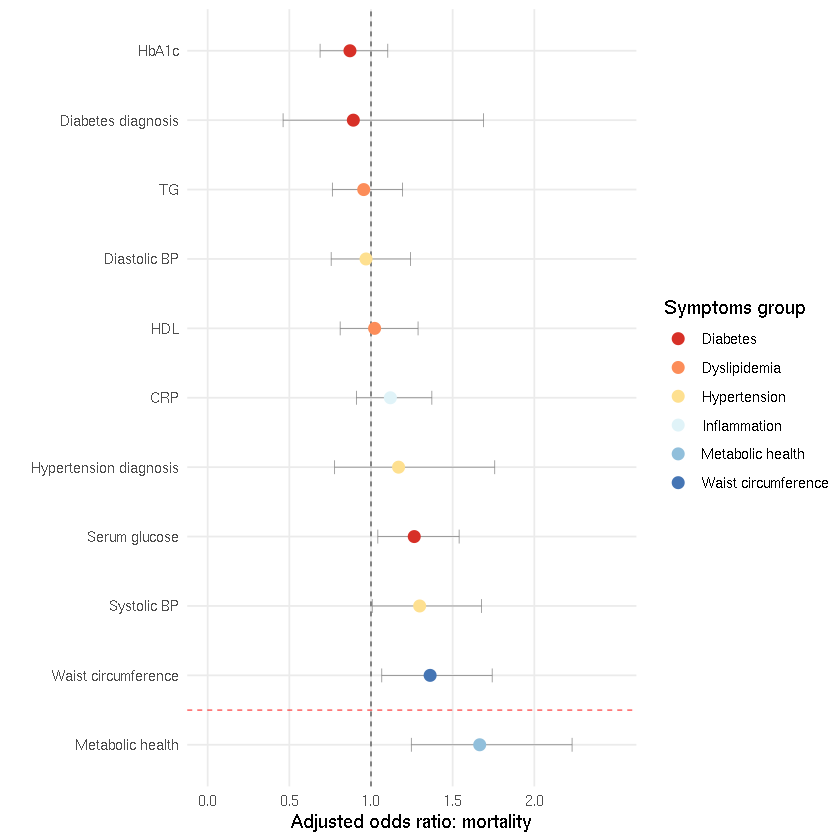

In [60]:
(p_death <- ggplot(ORs_mortality, aes(x = (V1), y = reorder(names, -V1))) + 
    geom_vline(aes(xintercept = 1), size = .25, linetype = "dashed") + 
    geom_errorbarh(aes(xmax = X97.5.., xmin = X2.5..), size = 0.2, height = 0.2, color = "gray50") +
    geom_point(size = 3, aes(color = Symptomsgroup)) +
    scale_x_continuous(breaks = c(0,0.5,1,1.5,2),
                       limits = c(0,2.5)) +
    theme_minimal() +
    theme(panel.grid.minor = element_blank()) +
    ylab("") +
    xlab("Adjusted odds ratio: mortality") + 
    #ggtitle("B") +
    scale_color_brewer(palette="RdYlBu", name='Symptoms group') +
    geom_hline(aes(yintercept = 1.5), size = .25, color='red', linetype='dashed') 
 )

ggsave('/dagher/dagher11/filip/COVID/COVID_mortality.tiff',
  plot = p_death,
  device = 'tiff',
  scale = 1,
  width = 15,
  height = 10,
  units = 'cm',
  dpi = 300
)